# <center> Predicting Stroke Events  
### <center> Adam Brenner

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Load in the stroke dataset
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
# Looks like a combination between categorical and numerical data
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# ID will not be of much use to us in this project so drop it
stroke_data = stroke_data.drop(columns = ['id'])

In [5]:
# 5110 rows and 11 columns
stroke_data.shape

(5110, 11)

In [6]:
# Checking that the columns don't have extra spaces around their names and lowercasing Residence_type to match the rest
# of the columns
stroke_data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [7]:
stroke_data.columns = stroke_data.columns.str.lower()

In [8]:
# Checking for missing data
stroke_data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [9]:
# Instead of deleting the missing data rows, we will put in the mean of each bmi by gender
stroke_data.groupby('gender').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
gender,,,,,,
Female,43.757395,0.092184,0.037742,104.057809,29.065758,0.047094
Male,42.483385,0.104965,0.077069,109.088520,28.647936,0.051064
Other,26.000000,0.000000,0.000000,143.330000,22.400000,0.000000


In [10]:
# This groups the dataset by gender then fills in the missing values of that gender with the mean of that genders bmi
stroke_data['bmi'] = stroke_data.groupby('gender').transform(lambda x: x.fillna(x.mean()))

In [11]:
stroke_data.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [12]:
# There are some categorical columns that need to be encoded to numeric
stroke_data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [13]:
for c in stroke_data.columns:
    if stroke_data[c].dtypes == object:
        print(c, ":", stroke_data[c].unique())

gender : ['Male' 'Female' 'Other']
ever_married : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [14]:
# Lets look at the frequency tables for the categorical variables
for c in stroke_data.columns:
    if stroke_data[c].dtypes == object:
        print(pd.crosstab(index = stroke_data[c], columns = 'count'), "\n")
#pd.crosstab(index = stroke_data['gender'], columns = 'count')

col_0   count
gender       
Female   2994
Male     2115
Other       1 

col_0         count
ever_married       
No             1757
Yes            3353 

col_0          count
work_type           
Govt_job         657
Never_worked      22
Private         2925
Self-employed    819
children         687 

col_0           count
residence_type       
Rural            2514
Urban            2596 

col_0            count
smoking_status        
Unknown           1544
formerly smoked    885
never smoked      1892
smokes             789 



In [15]:
stroke_data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,43.226614,0.048728
std,22.612647,0.296607,0.226063,45.283560,22.612647,0.215320
min,0.080000,0.000000,0.000000,55.120000,0.080000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,25.000000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,45.000000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,61.000000,0.000000
max,82.000000,1.000000,1.000000,271.740000,82.000000,1.000000


In [16]:
# Lets remove any age under 14 as this will reduce some of the unbalance between the zeros and one values for stroke
stroke_data[stroke_data['age'] < 14]['stroke'].value_counts()

0    644
1      1
Name: stroke, dtype: int64

In [17]:
stroke_data = stroke_data.drop(stroke_data[stroke_data['age'] < 14].index)

In [18]:
stroke_data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4465.000000,4465.000000,4465.000000,4465.000000,4465.000000,4465.000000
mean,48.565062,0.111534,0.061590,107.926152,48.565062,0.055543
std,18.893337,0.314828,0.240437,47.133912,18.893337,0.229063
min,14.000000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,33.000000,0.000000,0.000000,77.460000,33.000000,0.000000
50%,49.000000,0.000000,0.000000,92.220000,49.000000,0.000000
75%,63.000000,0.000000,0.000000,115.920000,63.000000,0.000000
max,82.000000,1.000000,1.000000,271.740000,82.000000,1.000000


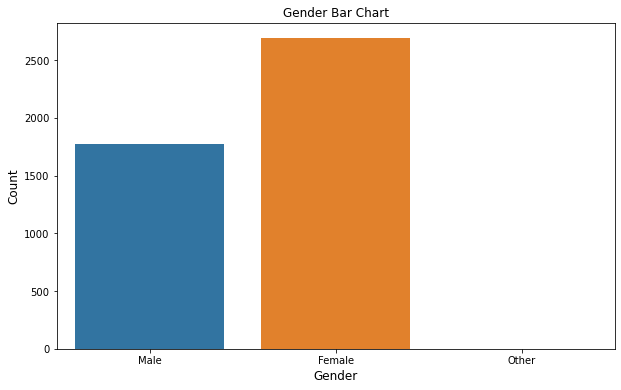

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'gender', data = stroke_data)
plt.title('Gender Bar Chart')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

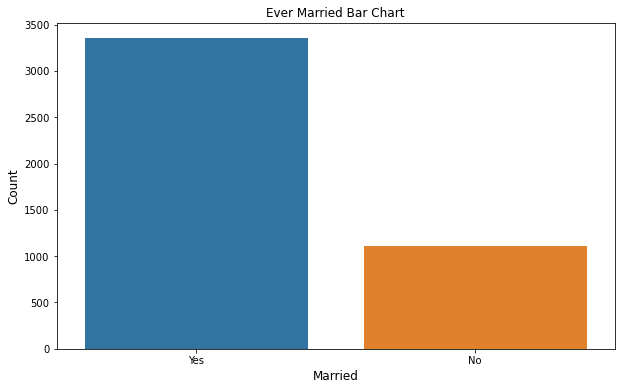

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'ever_married', data = stroke_data)
plt.title('Ever Married Bar Chart')
plt.xlabel('Married', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

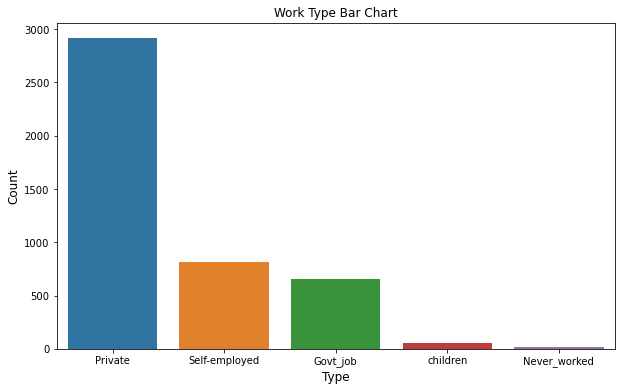

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'work_type', data = stroke_data)
plt.title('Work Type Bar Chart')
plt.xlabel('Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

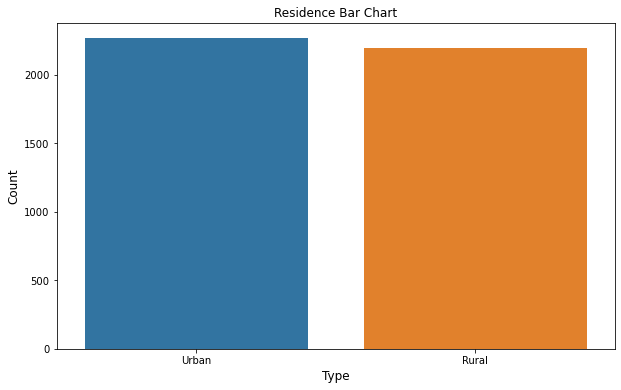

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'residence_type', data = stroke_data)
plt.title('Residence Bar Chart')
plt.xlabel('Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

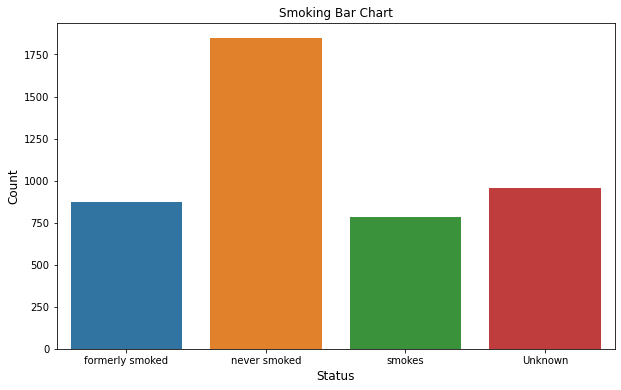

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'smoking_status', data = stroke_data)
plt.title('Smoking Bar Chart')
plt.xlabel('Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

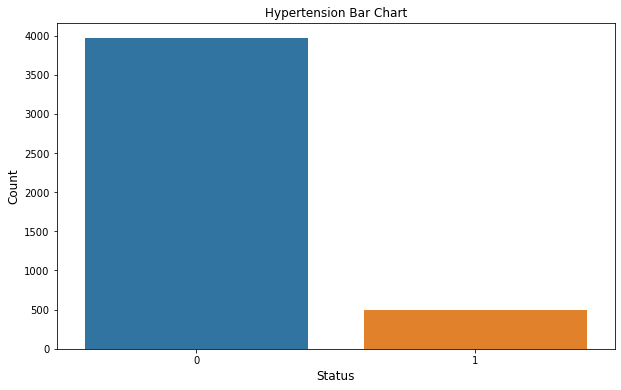

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'hypertension', data = stroke_data)
plt.title('Hypertension Bar Chart')
plt.xlabel('Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

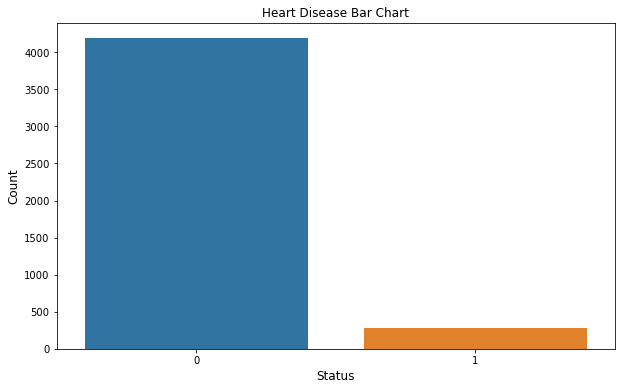

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'heart_disease', data = stroke_data)
plt.title('Heart Disease Bar Chart')
plt.xlabel('Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

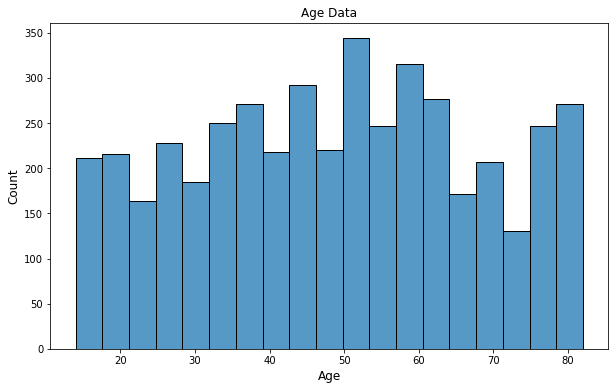

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(x = 'age', data = stroke_data)
plt.title('Age Data')
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

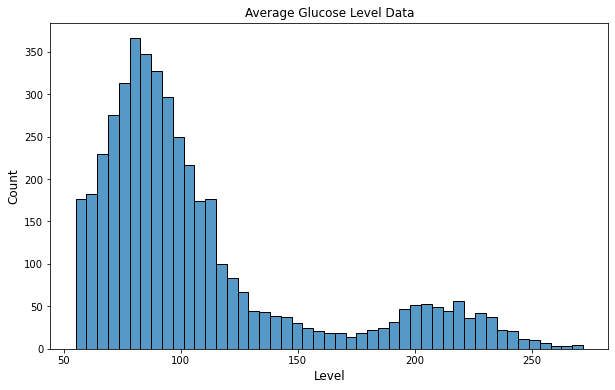

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(x = 'avg_glucose_level', data = stroke_data)
plt.title('Average Glucose Level Data')
plt.xlabel('Level', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

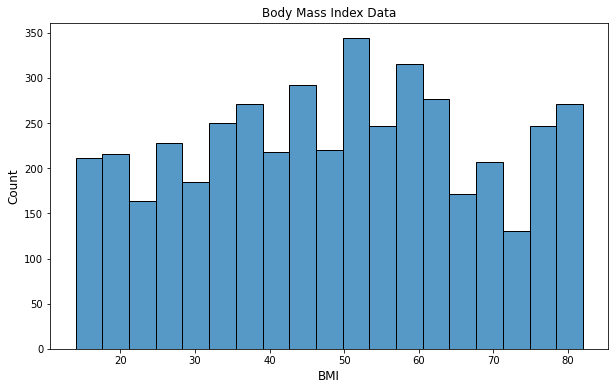

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(x = 'bmi', data = stroke_data)
plt.title('Body Mass Index Data')
plt.xlabel('BMI', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

In [29]:
stroke_data['gender_cat'] = stroke_data['gender'].astype('category').cat.codes
stroke_data['ever_married_cat'] = stroke_data['ever_married'].astype('category').cat.codes
stroke_data['work_type_cat'] = stroke_data['work_type'].astype('category').cat.codes
stroke_data['residence_type_cat'] = stroke_data['residence_type'].astype('category').cat.codes
stroke_data['smoking_status_cat'] = stroke_data['smoking_status'].astype('category').cat.codes

In [30]:
stroke_data = stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status'])

In [31]:
stroke_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_cat,ever_married_cat,work_type_cat,residence_type_cat,smoking_status_cat
0,67.0,0,1,228.69,67.0,1,1,1,2,1,1
1,61.0,0,0,202.21,61.0,1,0,1,3,0,2
2,80.0,0,1,105.92,80.0,1,1,1,2,0,2
3,49.0,0,0,171.23,49.0,1,0,1,2,1,3
4,79.0,1,0,174.12,79.0,1,0,1,3,0,2


In [32]:
stroke_data['stroke'].value_counts()

0    4217
1     248
Name: stroke, dtype: int64

In [33]:
features = stroke_data.drop(columns = ['stroke'])
target = stroke_data['stroke'].values

In [34]:
scaler = StandardScaler()
min_max = MinMaxScaler()

In [35]:
features_scaled = scaler.fit_transform(features)
features_min_max = min_max.fit_transform(features)

In [36]:
# Random seed set so the categorical naive bayes will work
np.random.seed(16)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=.3)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features_min_max, target, test_size=.3)

In [37]:
dec_clf = DecisionTreeClassifier().fit(X_train, y_train)
dec_clf_pred = dec_clf.predict(X_test)

In [38]:
cat_nb = CategoricalNB().fit(X_train2, y_train2)
cat_nb_pred = cat_nb.predict(X_test2)

In [39]:
knn = KNeighborsClassifier().fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [40]:
print("Decision Tree Accuracy: ", metrics.accuracy_score(y_test, dec_clf_pred))

Decision Tree Accuracy:  0.9126865671641791


In [41]:
print("Naive Bayes Accuracy: ", metrics.accuracy_score(y_test2, cat_nb_pred))

Naive Bayes Accuracy:  0.9365671641791045


In [42]:
print("KNN Accuracy: ", metrics.accuracy_score(y_test, knn_pred))

KNN Accuracy:  0.9417910447761194


In [43]:
print(metrics.classification_report(y_test2, cat_nb_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1270
           1       0.00      0.00      0.00        70

    accuracy                           0.94      1340
   macro avg       0.47      0.49      0.48      1340
weighted avg       0.90      0.94      0.92      1340



In [44]:
cat_nb_pred2 = cat_nb.predict(X_train2)
print("Training Accuracy: ", metrics.accuracy_score(y_train2, cat_nb_pred2))

Training Accuracy:  0.9376


In [45]:
vifs = pd.Series(np.linalg.inv(stroke_data.corr().to_numpy()).diagonal(), 
                 index=stroke_data.columns, 
                 name='VIF')

In [46]:
print(vifs)

age                  -2.925924e+32
hypertension          1.094832e+00
heart_disease        -1.341018e-18
avg_glucose_level     1.079116e+00
bmi                  -2.925924e+32
stroke                1.080393e+00
gender_cat            1.006978e+00
ever_married_cat      1.412038e+00
work_type_cat         1.010493e+00
residence_type_cat    1.001208e+00
smoking_status_cat    1.012625e+00
Name: VIF, dtype: float64


In [47]:
x = []
y = []
for i in range(1, 6):
    dec_clf = DecisionTreeClassifier(max_depth = i).fit(X_train, y_train)
    dec_clf_pred = dec_clf.predict(X_test)
    print("Max Depth: ", i, "Accuracy: ", metrics.accuracy_score(y_test, dec_clf_pred))
    x.append(i)
    y.append(metrics.accuracy_score(y_test, dec_clf_pred))

Max Depth:  1 Accuracy:  0.9447761194029851
Max Depth:  2 Accuracy:  0.9447761194029851
Max Depth:  3 Accuracy:  0.9447761194029851
Max Depth:  4 Accuracy:  0.9425373134328359
Max Depth:  5 Accuracy:  0.9417910447761194


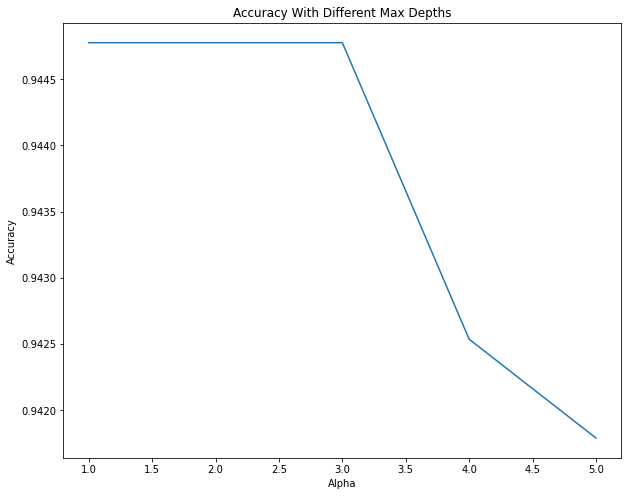

In [48]:
plt.figure(figsize=(10, 8))
plt.plot(x, y)
plt.title('Accuracy With Different Max Depths')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

In [49]:
x = []
y = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    print("# Neighbors: ", i, "Accuracy: ", metrics.accuracy_score(y_test, knn_pred))
    x.append(i)
    y.append(metrics.accuracy_score(y_test, knn_pred))

# Neighbors:  1 Accuracy:  0.908955223880597
# Neighbors:  2 Accuracy:  0.9402985074626866
# Neighbors:  3 Accuracy:  0.9328358208955224
# Neighbors:  4 Accuracy:  0.9432835820895522
# Neighbors:  5 Accuracy:  0.9417910447761194
# Neighbors:  6 Accuracy:  0.9447761194029851
# Neighbors:  7 Accuracy:  0.9432835820895522
# Neighbors:  8 Accuracy:  0.9447761194029851
# Neighbors:  9 Accuracy:  0.9440298507462687


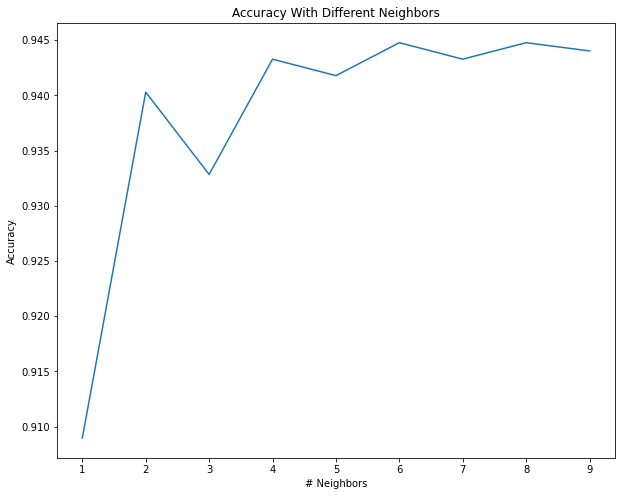

In [50]:
plt.figure(figsize=(10, 8))
plt.plot(x, y)
plt.title('Accuracy With Different Neighbors')
plt.xlabel('# Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [51]:
dec_cm = confusion_matrix(y_test, dec_clf_pred)

In [52]:
cat_nb_cm = confusion_matrix(y_test2, cat_nb_pred)

In [53]:
knn_cm = confusion_matrix(y_test, knn_pred)

Text(0.5, 1.0, 'Decision Tree')

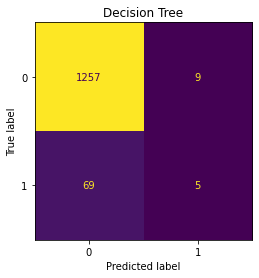

In [54]:
ConfusionMatrixDisplay(confusion_matrix= dec_cm, display_labels=dec_clf.classes_).plot(colorbar = False)
plt.title('Decision Tree')

Text(0.5, 1.0, 'Naive Bayes')

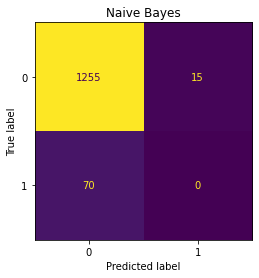

In [55]:
ConfusionMatrixDisplay(confusion_matrix= cat_nb_cm, display_labels=cat_nb.classes_).plot(colorbar=False)
plt.title('Naive Bayes')

Text(0.5, 1.0, 'KNN')

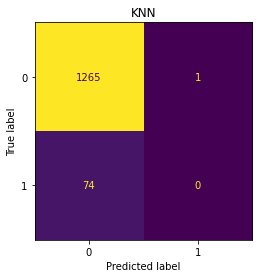

In [56]:
ConfusionMatrixDisplay(confusion_matrix= knn_cm, display_labels=knn.classes_).plot(colorbar=False)
plt.title('KNN')

In [58]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=.3)
    
    dec_clf = DecisionTreeClassifier().fit(X_train, y_train)
    dec_clf_pred = dec_clf.predict(X_test)
    
    print("Accuracy: ", round(metrics.accuracy_score(y_test, dec_clf_pred), 2))
    
    print(confusion_matrix(y_test, dec_clf_pred))

Accuracy:  0.9
[[1188   79]
 [  55   18]]
Accuracy:  0.91
[[1202   65]
 [  61   12]]
Accuracy:  0.9
[[1191   76]
 [  59   14]]
Accuracy:  0.89
[[1183   76]
 [  72    9]]
Accuracy:  0.91
[[1199   68]
 [  59   14]]
Accuracy:  0.9
[[1191   69]
 [  67   13]]
Accuracy:  0.89
[[1183   96]
 [  47   14]]
Accuracy:  0.9
[[1190   76]
 [  62   12]]
Accuracy:  0.89
[[1185   69]
 [  78    8]]
Accuracy:  0.9
[[1188   81]
 [  55   16]]
